## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from itertools import chain, cycle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from random import sample
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
98527,00026041_002.png,No Finding,2,26041,41,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_011/images/00026041_002.png
39805,00010394_002.png,No Finding,2,10394,36,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_005/images/00010394_002.png
39354,00010314_003.png,No Finding,3,10314,67,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_005/images/00010314_003.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
52952,00013347_000.png,Atelectasis,0,13347,51,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46890,00011960_006.png,Effusion|Pneumonia,6,11960,67,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
93644,00023535_001.png,No Finding,1,23535,49,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 'True' if x==1.0 else 'False')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
5776,00001558_006.png,Atelectasis|Consolidation|Effusion|Infiltration,6,1558,55,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False
28202,00007346_005.png,No Finding,5,7346,43,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
51240,00012939_002.png,Effusion,2,12939,57,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, test_data = train_test_split(vargs, test_size = 0.2, stratify = vargs['pneumonia_class'])
    
    p_inds = train_data[train_data.Pneumonia==1].index.tolist()
    np_inds = train_data[train_data.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    p_inds_2 = test_data[test_data.Pneumonia==1].index.tolist()
    np_inds_2 = test_data[test_data.Pneumonia==0].index.tolist()
    
    np_sample_2 = sample(np_inds_2,4*len(p_inds_2))
    test_data = test_data.loc[p_inds_2 + np_sample_2]
    
    return train_data, test_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [6]:
IMG_SIZE = (224, 224)

def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    if vargs == 'train':
        my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    else:
        my_idg = ImageDataGenerator(rescale=0,
                              horizontal_flip = False, 
                              vertical_flip = False, 
                              height_shift_range= 0, 
                              width_shift_range=0, 
                              rotation_range=0, 
                              shear_range = 0,
                              zoom_range=0)
    
    return my_idg


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = my_image_augmentation('train')
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = IMG_SIZE, 
                                          batch_size = 16
                                          )
     # Todo

    return train_gen


def make_val_gen(vargs):
    
    my_val_idg = my_image_augmentation('validate')
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = IMG_SIZE, 
                                              batch_size = 16) 
    
    # Todo
    return val_gen

train_data, val_data = create_splits(all_xray_df)

In [7]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.


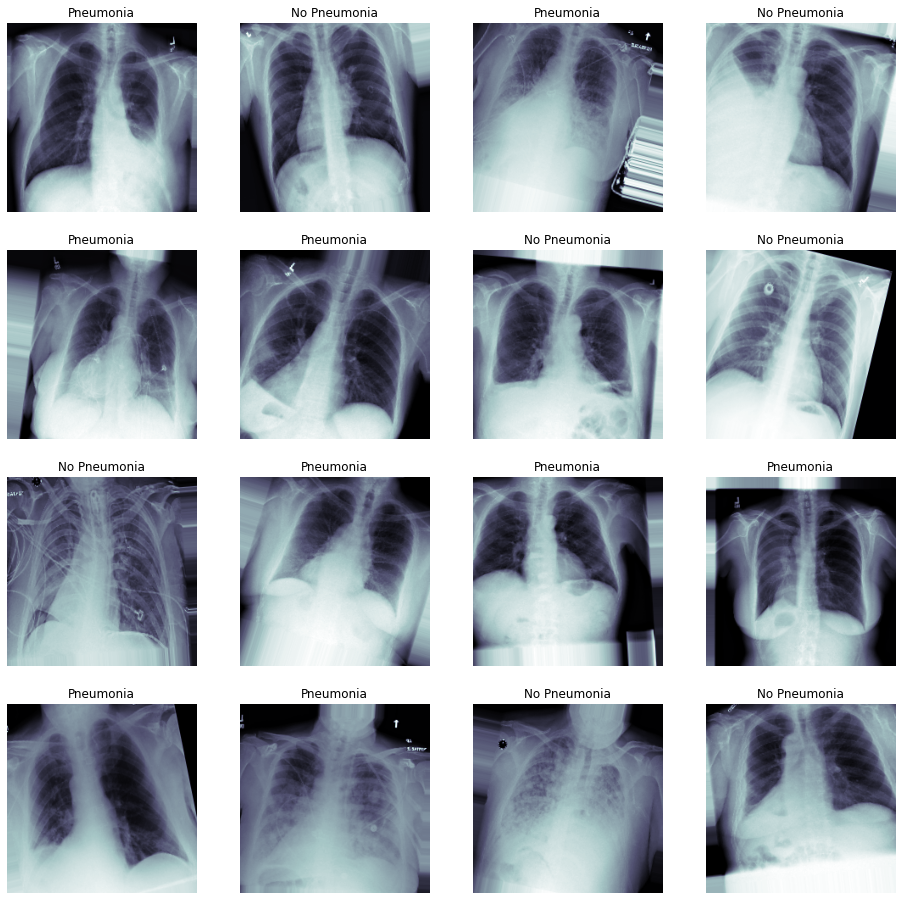

In [8]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

train_gen = make_train_gen(train_data)
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [9]:
def load_pretrained_model(vargs):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    # Todo
    
    return vgg_model


In [10]:
def build_my_model(vargs):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    my_model.add(load_pretrained_model([]))
    
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))
    
    
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [11]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                           monitor= 'binary_accuracy', 
                           verbose=1, 
                           save_best_only=True, 
                           mode= 'max', 
                           save_weights_only = True)

early = EarlyStopping(monitor='binary_accuracy', 
                       mode= 'max', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [12]:
## train your model

# Todo

my_model = build_my_model([])

history = my_model.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 30, 
                           callbacks = callbacks_list)

553467904/553467096 [==============================] - 9s 0us/step
Epoch 1/30
144/144 [==============================] - 90s 626ms/step - loss: 0.7694 - binary_accuracy: 0.5223 - val_loss: 2.7179 - val_binary_accuracy: 0.7888

Epoch 00001: binary_accuracy improved from -inf to 0.52227, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
144/144 [==============================] - 77s 536ms/step - loss: 0.7043 - binary_accuracy: 0.5585 - val_loss: 4.3585 - val_binary_accuracy: 0.7825

Epoch 00002: binary_accuracy improved from 0.52227 to 0.55852, saving model to xray_class_my_model.best.hdf5
Epoch 3/30
144/144 [==============================] - 78s 539ms/step - loss: 0.6858 - binary_accuracy: 0.5716 - val_loss: 0.3111 - val_binary_accuracy: 0.7713

Epoch 00003: binary_accuracy improved from 0.55852 to 0.57162, saving model to xray_class_my_model.best.hdf5
Epoch 4/30
144/144 [==============================] - 77s 534ms/step - loss: 0.6650 - binary_accuracy: 0.5873 - val_loss: 8.3848 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [13]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)
print(str(valY))
print(str(pred_Y))

16/16 [==============================] - 0s 14ms/step
[0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
[[2.2825059e-33]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.1517308e-15]
 [2.6063940e-34]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [5.9356630e-31]
 [9.2257999e-15]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.0353074e-24]
 [1.2241919e-17]
 [0.0000000e+00]
 [6.9303379e-24]]


In [14]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1, 1, figsize = (9,9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

## what other performance statistics do you want to include here besides AUC? 
    
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Pneumonia")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

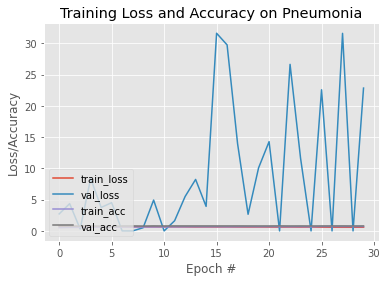

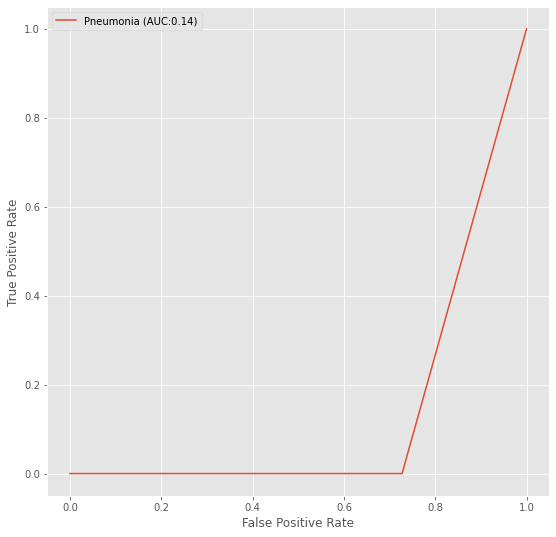

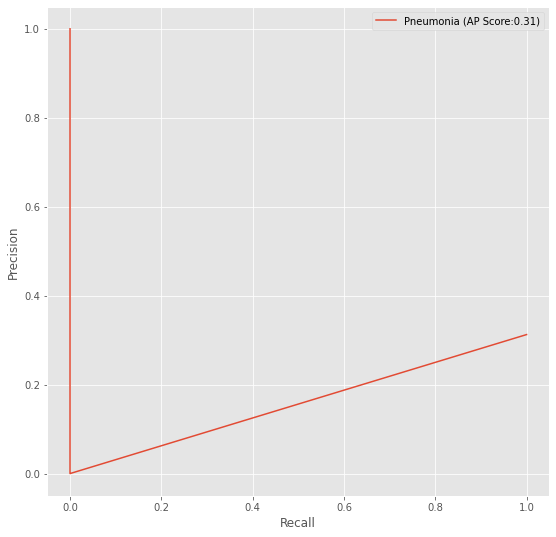

In [15]:
## plot figures

plot_history(history)
plot_auc(valY, pred_Y)
plot_precision_recall_curve(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [16]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

In [17]:
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 1.0
Recall is: 0.0


IndexError: index 9 is out of bounds for axis 0 with size 9

In [18]:
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.3125
Recall is: 1.0
Threshold is: 0.0
F1 Score is: 0.47619047619047616


In [19]:
def plot_f1_thresh(prec, rec, thresh):
    f1 = []
    f1 = calc_f1(prec, rec)
    print(str(f1))
    print(str(thresh))
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(thresh, f1[:len(f1)-1])
    c_ax.set_ylabel("F1")
    c_ax.set_xlabel('Threshold')

[0.47619048        nan        nan        nan        nan        nan
        nan        nan        nan 0.        ]
[0.0000000e+00 2.6063940e-34 2.2825059e-33 5.9356630e-31 3.0353074e-24
 6.9303379e-24 1.2241919e-17 1.1517308e-15 9.2257999e-15]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


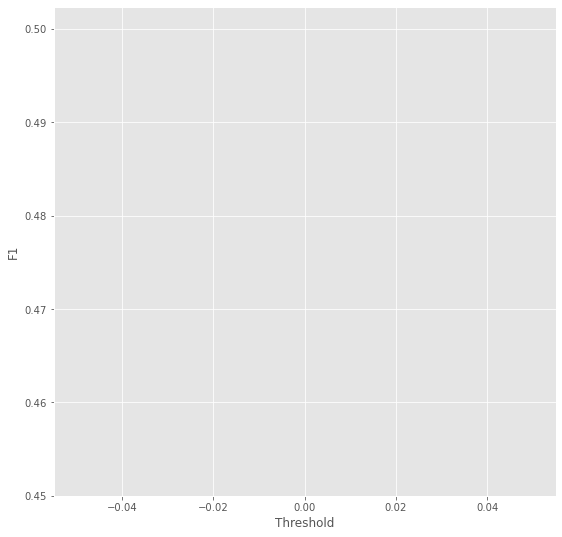

In [20]:
plot_f1_thresh(precision, recall, thresholds)

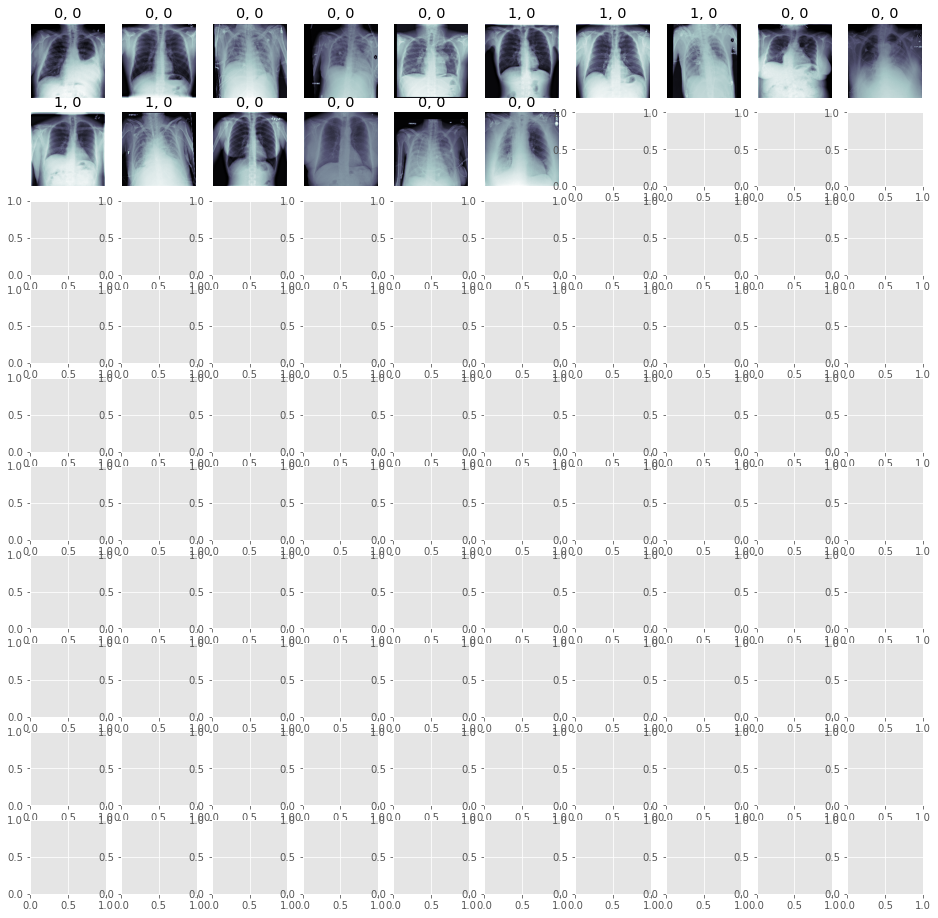

In [22]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] >  0.55891234:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] >  0.55891234: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)